In [1]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import logging
import multiprocessing
from tqdm import tqdm
from functools import reduce

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import scipy.stats as stats
from sklearn.metrics import median_absolute_error

import numpyro
import numpyro.distributions as dist

from hbmep.model import Baseline
from hbmep_paper.utils.constants import HBM
from hbmep.config import Config
from hbmep.model.utils import Site as site

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()

logger = logging.getLogger(__name__)


In [2]:
class Simulation(Baseline):
    LINK = HBM

    def __init__(self, config: Config, mu_a_delta: int, sigma_a_delta: int):
        super(Simulation, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]
        self.mu_a_delta = mu_a_delta
        self.sigma_a_delta = sigma_a_delta

    def _model(self, subject, features, intensity, response_obs=None):
        subject, n_subject = subject
        features, n_features = features
        intensity, n_data = intensity

        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample(
                    "mu_a_baseline",
                    dist.TruncatedNormal(50, 50, low=0)
                )
                sigma_a_baseline = numpyro.sample(
                    "sigma_a_baseline",
                    dist.HalfNormal(50)
                )

                sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(mu_a_baseline, sigma_a_baseline, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(sigma_b_baseline))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(sigma_v_baseline))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(sigma_L_baseline))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(sigma_H_baseline))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.deterministic("mu_a_delta", self.mu_a_delta)
                sigma_a_delta = numpyro.deterministic("sigma_a_delta", self.sigma_a_delta)

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        # """ Penalty """
        # penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        # numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )



In [3]:
class HierarchicalBayesianModel(Baseline):
    LINK = HBM

    def __init__(self, config: Config):
        super(HierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                """ Hyper-priors """
                mu_a_baseline = numpyro.sample(
                    "mu_a_baseline",
                    dist.TruncatedNormal(50, 50, low=0)
                )
                sigma_a_baseline = numpyro.sample(
                    "sigma_a_baseline",
                    dist.HalfNormal(50)
                )

                sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(mu_a_baseline, sigma_a_baseline, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(sigma_b_baseline))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(sigma_v_baseline))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(sigma_L_baseline))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(sigma_H_baseline))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(mu_a_delta, sigma_a_delta))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        # """ Penalty """
        # penalty = (jnp.fabs(baseline + delta) - (baseline + delta))
        # numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [4]:
class NonHierarchicalBayesianModel(Baseline):
    LINK = "non_hierarchical_bayesian"

    def __init__(self, config: Config):
        super(NonHierarchicalBayesianModel, self).__init__(config=config)
        self.combination_columns = self.features + [self.subject]

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        n_baseline = 1
        n_delta = 1

        # global_sigma_b_baseline = numpyro.sample("global_sigma_b_baseline", dist.HalfNormal(100))
        # global_sigma_v_baseline = numpyro.sample("global_sigma_v_baseline", dist.HalfNormal(100))

        # global_sigma_L_baseline = numpyro.sample("global_sigma_L_baseline", dist.HalfNormal(50))
        # global_sigma_H_baseline = numpyro.sample("global_sigma_H_baseline", dist.HalfNormal(500))

        # global_sigma_g_1_baseline = numpyro.sample("global_sigma_g_1_baseline", dist.HalfNormal(100))
        # global_sigma_g_2_baseline = numpyro.sample("global_sigma_g_2_baseline", dist.HalfNormal(100))

        """ Baseline """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_baseline", n_baseline, dim=-2):
                # """ Hyper-priors """
                # mu_a_baseline = numpyro.sample(
                #     "mu_a_baseline",
                #     dist.TruncatedNormal(50, 50, low=0)
                # )
                # sigma_a_baseline = numpyro.sample(
                #     "sigma_a_baseline",
                #     dist.HalfNormal(50)
                # )

                # sigma_b_baseline = numpyro.sample("sigma_b_baseline", dist.HalfNormal(global_sigma_b_baseline))
                # sigma_v_baseline = numpyro.sample("sigma_v_baseline", dist.HalfNormal(global_sigma_v_baseline))

                # sigma_L_baseline = numpyro.sample("sigma_L_baseline", dist.HalfNormal(global_sigma_L_baseline))
                # sigma_H_baseline = numpyro.sample("sigma_H_baseline", dist.HalfNormal(global_sigma_H_baseline))

                # sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(global_sigma_g_1_baseline))
                # sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(global_sigma_g_2_baseline))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    """ Priors """
                    a_baseline = numpyro.sample(
                        "a_baseline",
                        dist.TruncatedNormal(50, 100, low=0)
                    )

                    b_baseline = numpyro.sample("b_baseline", dist.HalfNormal(100))
                    v_baseline = numpyro.sample("v_baseline", dist.HalfNormal(100))

                    L_baseline = numpyro.sample("L_baseline", dist.HalfNormal(50))
                    H_baseline = numpyro.sample("H_baseline", dist.HalfNormal(500))

                    sigma_g_1_baseline = numpyro.sample("sigma_g_1_baseline", dist.HalfNormal(100))
                    sigma_g_2_baseline = numpyro.sample("sigma_g_2_baseline", dist.HalfNormal(100))

                    g_1_baseline = numpyro.sample("g_1_baseline", dist.Exponential(sigma_g_1_baseline))
                    g_2_baseline = numpyro.sample("g_2_baseline", dist.Exponential(sigma_g_2_baseline))

        """ Delta """
        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_delta", n_delta, dim=-2):
                # mu_a_delta = numpyro.sample("mu_a_delta", dist.Normal(0, 100))
                # sigma_a_delta = numpyro.sample("sigma_a_delta", dist.HalfNormal(100))

                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a_delta = numpyro.sample("a_delta", dist.Normal(0, 100))

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate("n_feature0", n_feature0, dim=-2):
                with numpyro.plate(site.n_subject, n_subject, dim=-3):
                    a = numpyro.deterministic(
                        site.a,
                        jnp.concatenate([a_baseline, a_baseline + a_delta], axis=1)
                    )

                    b = numpyro.deterministic(
                        site.b,
                        jnp.concatenate([b_baseline, b_baseline], axis=1)
                    )
                    v = numpyro.deterministic(
                        site.v,
                        jnp.concatenate([v_baseline, v_baseline], axis=1)
                    )

                    L = numpyro.deterministic(
                        site.L,
                        jnp.concatenate([L_baseline, L_baseline], axis=1)
                    )
                    H = numpyro.deterministic(
                        site.H,
                        jnp.concatenate([H_baseline, H_baseline], axis=1)
                    )

                    g_1 = numpyro.deterministic(
                        site.g_1,
                        jnp.concatenate([g_1_baseline, g_1_baseline], axis=1)
                    )
                    g_2 = numpyro.deterministic(
                        site.g_2,
                        jnp.concatenate([g_2_baseline, g_2_baseline], axis=1)
                    )

                    # a = numpyro.deterministic(site.a, a_baseline)

                    # b = numpyro.deterministic(site.b, b_baseline)
                    # v = numpyro.deterministic(site.v, v_baseline)

                    # L = numpyro.deterministic(site.L, L_baseline)
                    # H = numpyro.deterministic(site.H, H_baseline)

                    # g_1 = numpyro.deterministic(site.g_1, g_1_baseline)
                    # g_2 = numpyro.deterministic(site.g_2, g_2_baseline)

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[subject, feature0]
            + jnp.maximum(
                0,
                -1
                + (H[subject, feature0] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[subject, feature0], v[subject, feature0]) - 1)
                    * jnp.exp(-b[subject, feature0] * (intensity - a[subject, feature0])),
                    1 / v[subject, feature0]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[subject, feature0] + g_2[subject, feature0] * (1 / mu) ** 2
        )

        """ Penalty """
        penalty = (jnp.fabs(a_baseline + a_delta) - (a_baseline + a_delta))
        numpyro.factor("penalty", -penalty)

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )


In [5]:
mu_a_delta = -1.5
sigma_a_delta = 1

toml_path = "/home/vishu/repos/hbmep-paper/configs/human/tms/mixed-effects.toml"
CONFIG = Config(toml_path=toml_path)

MODEL = Simulation(config=CONFIG, mu_a_delta=mu_a_delta, sigma_a_delta=sigma_a_delta)

src = "/home/vishu/data/hbmep-processed/human/tms/data_pkpk_auc.csv"
DF = pd.read_csv(src)

DF[MODEL.features[0]] = 0
DF[MODEL.response] = DF[MODEL.response] * 1000

DF, ENCODER_DICT = MODEL.load(df=DF)

dest = os.path.join(MODEL.build_dir, "inference.pkl")
with open(dest, "rb") as g:
    _, MCMC, POSTERIOR_SAMPLES = pickle.load(g)

2023-12-28 14:07:46,239 - hbmep.config - INFO - Verifying configuration ...
2023-12-28 14:07:46,239 - hbmep.config - INFO - Success!
2023-12-28 14:07:46,253 - hbmep.model.baseline - INFO - Initialized base_model
2023-12-28 14:07:46,261 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects
2023-12-28 14:07:46,261 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/human/tms/fit/mixed-effects
2023-12-28 14:07:46,262 - hbmep.dataset.core - INFO - Processing data ...
2023-12-28 14:07:46,263 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [6]:
prefix = "hbm-vs-nhbm"
prefix_2 = f"mu_a_delta_{mu_a_delta}_sigma_a_delta_{sigma_a_delta}"

priors = {
    site.a, "a_baseline",
    site.b, "b_baseline",
    site.v, "v_baseline",
    site.L, "L_baseline",
    site.H, "H_baseline",
    site.g_1, "g_1_baseline",
    site.g_2, "g_2_baseline",
    site.mu, site.beta
}

POST = {u: v for u, v in POSTERIOR_SAMPLES.items() if u not in priors}

""" Experiment """
TOTAL_SUBJECTS = 200

PREDICTION_DF = \
    pd.DataFrame(np.arange(0, TOTAL_SUBJECTS, 1), columns=[MODEL.subject]) \
    .merge(
        pd.DataFrame(np.arange(0, 2, 1), columns=MODEL.features),
        how="cross"
    ) \
    .merge(
        pd.DataFrame([0, 100], columns=[MODEL.intensity]),
        how="cross"
    )
PREDICTION_DF = MODEL.make_prediction_dataset(df=PREDICTION_DF, num=60)

POSTERIOR_PREDICTIVE = MODEL.predict(df=PREDICTION_DF, posterior_samples=POST)
OBS = np.array(POSTERIOR_PREDICTIVE[site.obs])

N_space = [1, 2, 4, 6, 8, 12, 16, 20]
# N_space = [2, 4, 6, 8, 10, 12]

keys = jax.random.split(MODEL.rng_key, num=2)

n_draws = 50
draws_space = \
    jax.random.choice(
        key=keys[0],
        a=np.arange(0, CONFIG.MCMC_PARAMS["num_chains"] * CONFIG.MCMC_PARAMS["num_samples"], 1),
        shape=(n_draws,),
        replace=False
    ) \
    .tolist()

n_repeats = 50
repeats_space = \
    jax.random.choice(
        key=keys[1],
        a=np.arange(0, n_repeats * 100, 1),
        shape=(n_repeats,),
        replace=False
    ) \
    .tolist()



2023-12-28 14:07:46,348 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec


2023-12-28 14:08:22,571 - hbmep.utils.utils - INFO - func:predict took: 36.22 sec


In [7]:
a = np.array(POSTERIOR_PREDICTIVE[site.a])
a.shape

(4000, 200, 2, 1)

In [8]:
N_LIM = 8
DRAW_LIM = 12
SEED_LIM = n_repeats

# N_LIM = 8
# DRAW_LIM = 1
# SEED_LIM = n_repeats

In [9]:
model_prefix = "hierarchical_bayesian"

mu_a_delta = None
p_value = None
a_error = None

for N in tqdm(N_space[:N_LIM], desc="N"):
    curr_N_mu_delta = None
    curr_N_p_value = None
    curr_N_a_error = None

    N_dir = f"N_{N}"

    for draw_ind in tqdm(draws_space[:DRAW_LIM], desc="Draw"):
        curr_draw_mu_delta = None
        curr_draw_p_value = None
        curr_draw_a_error = None

        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space[:SEED_LIM]:
            seed_dir = f"seed_{seed}"

            """ Posterior samples """
            src = os.path.join(MODEL.build_dir, prefix, model_prefix, prefix_2, draw_dir, N_dir, seed_dir, "inference.pkl")
            with open(src, "rb") as g:
                posterior_samples, = pickle.load(g)

            """ mu_a_delta """
            mu_delta_temp = posterior_samples["mu_a_delta"]

            mu_delta_temp = mu_delta_temp[None, ...]
            if curr_draw_mu_delta is None:
                curr_draw_mu_delta = mu_delta_temp
            else:
                curr_draw_mu_delta = np.concatenate([curr_draw_mu_delta, mu_delta_temp], axis=0)

            """ True threshold """
            subjects_ind = \
                jax.random.choice(
                    key=jax.random.PRNGKey(seed),
                    a=np.arange(0, TOTAL_SUBJECTS, 1),
                    shape=(N,),
                    replace=False
                ) \
                .tolist()
            a_true = a[draw_ind, ...]
            a_true = a_true[sorted(subjects_ind), ...]

            """ Estimated threshold """
            a_temp = np.array(posterior_samples[site.a].mean(axis=0))

            """ Error """
            mae_temp = np.abs(a_true - a_temp)
            mae_temp = mae_temp.reshape(-1,).mean().item()

            mse_temp = (a_true - a_temp) ** 2
            mse_temp = mse_temp.reshape(-1,).mean().item()

            median_error = median_absolute_error(y_true=a_true.reshape(-1,), y_pred=a_temp.reshape(-1,))

            error_temp = np.array([mae_temp, mse_temp, median_error])

            error_temp = error_temp[None, ...]
            if curr_draw_a_error is None:
                curr_draw_a_error = error_temp
            else:
                curr_draw_a_error = np.concatenate([curr_draw_a_error, error_temp], axis=0)

            """ p-value """
            diff = a_temp[..., 1, 0] - a_temp[..., 0, 0]
            diff = diff.reshape(-1,)

            ttest = stats.ttest_1samp(a=diff, popmean=0, alternative="less").pvalue
            ranktest = stats.wilcoxon(x=diff, alternative="less").pvalue

            p_value_temp = np.array([ttest, ranktest])

            p_value_temp = p_value_temp[None, ...]
            if curr_draw_p_value is None:
                curr_draw_p_value = p_value_temp
            else:
                curr_draw_p_value = np.concatenate([curr_draw_p_value, p_value_temp], axis=0)

        curr_draw_mu_delta = curr_draw_mu_delta[None, ...]
        if curr_N_mu_delta is None:
            curr_N_mu_delta = curr_draw_mu_delta
        else:
            curr_N_mu_delta = np.concatenate([curr_N_mu_delta, curr_draw_mu_delta], axis=0)

        curr_draw_a_error = curr_draw_a_error[None, ...]
        if curr_N_a_error is None:
            curr_N_a_error = curr_draw_a_error
        else:
            curr_N_a_error = np.concatenate([curr_N_a_error, curr_draw_a_error], axis=0)

        curr_draw_p_value = curr_draw_p_value[None, ...]
        if curr_N_p_value is None:
            curr_N_p_value = curr_draw_p_value
        else:
            curr_N_p_value = np.concatenate([curr_N_p_value, curr_draw_p_value], axis=0)

    curr_N_mu_delta = curr_N_mu_delta[None, ...]
    if mu_a_delta is None:
        mu_a_delta = curr_N_mu_delta
    else:
        mu_a_delta = np.concatenate([mu_a_delta, curr_N_mu_delta], axis=0)

    curr_N_a_error = curr_N_a_error[None, ...]
    if a_error is None:
        a_error = curr_N_a_error
    else:
        a_error = np.concatenate([a_error, curr_N_a_error], axis=0)

    curr_N_p_value = curr_N_p_value[None, ...]
    if p_value is None:
        p_value = curr_N_p_value
    else:
        p_value = np.concatenate([p_value, curr_N_p_value], axis=0)


N:   0%|                                                                                                                                                                        | 0/8 [00:00<?, ?it/s]/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in sc

In [10]:
hbm_mu_delta = mu_a_delta.copy()
hbm_error = a_error.copy()
hbm_p_value = p_value.copy()


In [11]:
# # N_LIM = 9
# DRAW_LIM = 12
# # SEED_LIM = n_repeats

model_prefix = "all_in"

p_value = None
a_error = None

for N in tqdm(N_space[:N_LIM], desc="N"):
    curr_N_p_value = None
    curr_N_a_error = None

    N_dir = f"N_{N}"

    for draw_ind in tqdm(draws_space[:DRAW_LIM], desc="Draw"):
        curr_draw_p_value = None
        curr_draw_a_error = None

        draw_dir = f"draw_{draw_ind}"

        for seed in repeats_space[:SEED_LIM]:
            seed_dir = f"seed_{seed}"

            """ True threshold """
            subjects_ind = \
                jax.random.choice(
                    key=jax.random.PRNGKey(seed),
                    a=np.arange(0, TOTAL_SUBJECTS, 1),
                    shape=(N,),
                    replace=False
                ) \
                .tolist()
            a_true = a[draw_ind, ...]
            a_true = a_true[sorted(subjects_ind), ...]

            a_pred = None
            for subject in sorted(subjects_ind):
                subject_dir = f"subject_{subject}"

                """ Posterior samples """
                src = os.path.join(MODEL.build_dir, prefix, model_prefix, prefix_2, draw_dir, N_dir, seed_dir, subject_dir, "inference.pkl")
                with open(src, "rb") as g:
                    posterior_samples, = pickle.load(g)

                """ Estimated threshold """
                a_temp = np.array(posterior_samples[site.a].mean(axis=0))

                if a_pred is None:
                    a_pred = a_temp
                else:
                    a_pred = np.concatenate([a_pred, a_temp], axis=0)

            """ Error """
            mae_temp = np.abs(a_true - a_pred)
            mae_temp = mae_temp.reshape(-1,).mean().item()

            mse_temp = (a_true - a_pred) ** 2
            mse_temp = mse_temp.reshape(-1,).mean().item()

            median_error = median_absolute_error(y_true=a_true.reshape(-1,), y_pred=a_pred.reshape(-1,))

            error_temp = np.array([mae_temp, mse_temp, median_error])

            error_temp = error_temp[None, ...]
            if curr_draw_a_error is None:
                curr_draw_a_error = error_temp
            else:
                curr_draw_a_error = np.concatenate([curr_draw_a_error, error_temp], axis=0)

            """ p-value """
            diff = a_pred[..., 1, 0] - a_pred[..., 0, 0]
            diff = diff.reshape(-1,)

            ttest = stats.ttest_1samp(a=diff, popmean=0, alternative="less").pvalue
            ranktest = stats.wilcoxon(x=diff, alternative="less").pvalue

            p_value_temp = np.array([ttest, ranktest])

            p_value_temp = p_value_temp[None, ...]
            if curr_draw_p_value is None:
                curr_draw_p_value = p_value_temp
            else:
                curr_draw_p_value = np.concatenate([curr_draw_p_value, p_value_temp], axis=0)

        curr_draw_a_error = curr_draw_a_error[None, ...]
        if curr_N_a_error is None:
            curr_N_a_error = curr_draw_a_error
        else:
            curr_N_a_error = np.concatenate([curr_N_a_error, curr_draw_a_error], axis=0)

        curr_draw_p_value = curr_draw_p_value[None, ...]
        if curr_N_p_value is None:
            curr_N_p_value = curr_draw_p_value
        else:
            curr_N_p_value = np.concatenate([curr_N_p_value, curr_draw_p_value], axis=0)

    curr_N_a_error = curr_N_a_error[None, ...]
    if a_error is None:
        a_error = curr_N_a_error
    else:
        a_error = np.concatenate([a_error, curr_N_a_error], axis=0)

    curr_N_p_value = curr_N_p_value[None, ...]
    if p_value is None:
        p_value = curr_N_p_value
    else:
        p_value = np.concatenate([p_value, curr_N_p_value], axis=0)

N:   0%|                                                                                                                                                                        | 0/8 [00:00<?, ?it/s]/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in scalar multiply
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: divide by zero encountered in divide
  var *= np.divide(n, n-ddof)  # to avoid error on division by zero
/home/vishu/repos/hbmep-paper/.venv/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1103: RuntimeWarning: invalid value encountered in sc

In [12]:
nhb_all_in_error = a_error.copy()
nhb_all_in_p_value = p_value.copy()


In [13]:
def _process(arr):
    me = arr.mean(axis=-1)
    sem = stats.sem(arr, axis=-1)
    std = arr.std(axis=-1)
    return me, sem, std

def _process_bp(arr):
    arr = ((arr < 0).mean(axis=(-1, -2, -3)) > .95).mean(axis=-1)
    return _process(arr)

def _process_fp(arr):
    arr = (arr < .05).mean(axis=-1)
    return _process(arr)


In [14]:
hbm_error.shape

(8, 12, 50, 3)

In [15]:
nhb_all_in_error.shape

(8, 12, 50, 3)

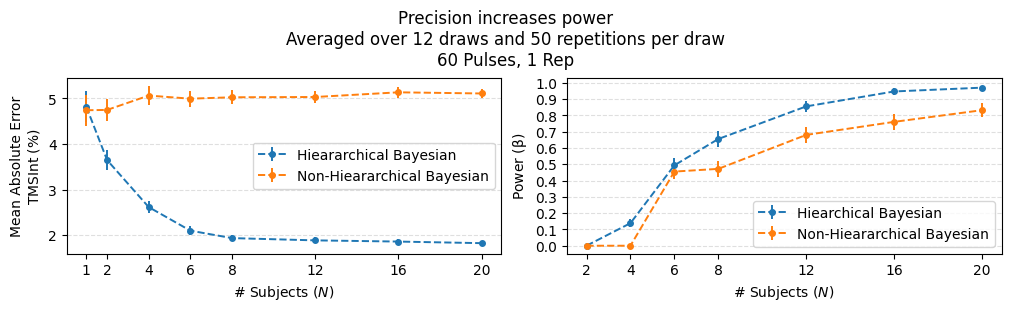

In [16]:
lw = 1.4

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

me, sem, std = _process(nhb_all_in_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=np.array(N_space[:N_LIM]), y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# # me, sem, std = _process(nhb_all_in_error[..., 2].reshape(N_LIM, -1))
# ax.errorbar(x=np.array(N_space[:N_LIM]), y=np.median(hbm_error[..., 0], axis=(-1, -2)), marker="o", label="Hieararchical Bayesian - 2", linestyle="--", linewidth=lw, ms=4)
# ax.errorbar(x=np.array(N_space[:N_LIM]), y=np.median(nhb_all_in_error[..., 0], axis=(-1, -2)), marker="o", label="Non-Hieararchical Bayesian - 2", linestyle="--", linewidth=lw, ms=4)

ax.legend()
# me, sem, std = _process(nhbm_error[..., 2].reshape(N_LIM, -1))
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)


# ax.legend()
ax.set_xticks(N_space[:N_LIM])
ax.set_ylabel("Mean Absolute Error\nTMSInt $(\%)$")
ax.set_xlabel("# Subjects $(N)$")
ax.grid(axis="y", linestyle="--", alpha=.4);

ax = axes[0, 1]
me, sem, std = _process_bp(hbm_mu_delta)
ax.errorbar(x=N_space[:N_LIM][1:], y=me[1:], yerr=sem[1:], marker="o", label="Hiearchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(hbm_p_value[..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb t-test")

# me, sem, std = _process_fp(hbm_p_value[..., 1])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb signed-rank")

# me, sem, std = _process_fp(nhbm_p_value[..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb t-test")

me, sem, std = _process_fp(nhb_all_in_p_value[..., 1])
ax.errorbar(x=N_space[:N_LIM][1:], y=me[1:], yerr=sem[1:], marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

ax.set_yticks(np.arange(0, 1.1, .1))
ax.grid(axis="y", linestyle="--", alpha=.4)
ax.set_xticks(N_space[:N_LIM][1:])
ax.legend(loc="lower right")
ax.set_xlabel("# Subjects $(N)$")
ax.set_ylabel("Power $($β$)$")
fig.suptitle("Precision increases power\nAveraged over 12 draws and 50 repetitions per draw\n60 Pulses, 1 Rep");

In [22]:
DRAW_LIM = 5

In [24]:
hbm_error[:, :DRAW_LIM, ..., 0].shape

(8, 5, 50)

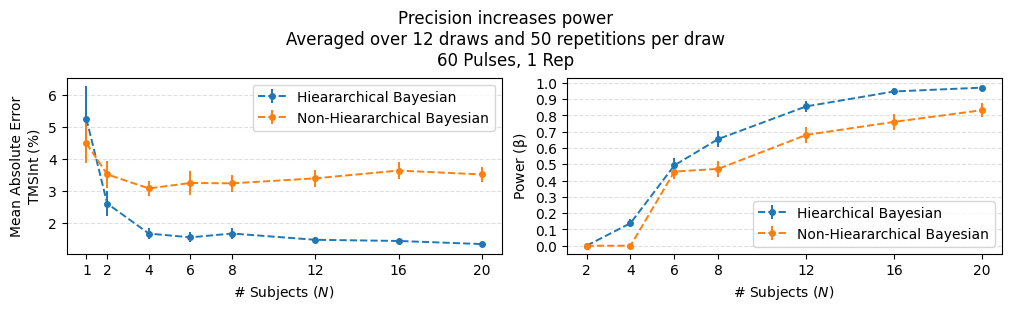

In [32]:
lw = 1.4
DRAW_LIM = 1

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[:, :DRAW_LIM, ..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

me, sem, std = _process(nhb_all_in_error[:, :DRAW_LIM, ..., 0].reshape(N_LIM, -1))
ax.errorbar(x=np.array(N_space[:N_LIM]), y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# # me, sem, std = _process(nhb_all_in_error[..., 2].reshape(N_LIM, -1))
# ax.errorbar(x=np.array(N_space[:N_LIM]), y=np.median(hbm_error[..., 0], axis=(-1, -2)), marker="o", label="Hieararchical Bayesian - 2", linestyle="--", linewidth=lw, ms=4)
# ax.errorbar(x=np.array(N_space[:N_LIM]), y=np.median(nhb_all_in_error[..., 0], axis=(-1, -2)), marker="o", label="Non-Hieararchical Bayesian - 2", linestyle="--", linewidth=lw, ms=4)

ax.legend()

# me, sem, std = _process(nhbm_error[..., 2].reshape(N_LIM, -1))
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)


# ax.legend()
ax.set_xticks(N_space[:N_LIM])
ax.set_ylabel("Mean Absolute Error\nTMSInt $(\%)$")
ax.set_xlabel("# Subjects $(N)$")
ax.grid(axis="y", linestyle="--", alpha=.4);

ax = axes[0, 1]
me, sem, std = _process_bp(hbm_mu_delta)
ax.errorbar(x=N_space[:N_LIM][1:], y=me[1:], yerr=sem[1:], marker="o", label="Hiearchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(hbm_p_value[..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb t-test")

# me, sem, std = _process_fp(hbm_p_value[..., 1])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb signed-rank")

# me, sem, std = _process_fp(nhbm_p_value[..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb t-test")

me, sem, std = _process_fp(nhb_all_in_p_value[..., 1])
ax.errorbar(x=N_space[:N_LIM][1:], y=me[1:], yerr=sem[1:], marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

ax.set_yticks(np.arange(0, 1.1, .1))
ax.grid(axis="y", linestyle="--", alpha=.4)
ax.set_xticks(N_space[:N_LIM][1:])
ax.legend(loc="lower right")
ax.set_xlabel("# Subjects $(N)$")
ax.set_ylabel("Power $($β$)$")
fig.suptitle("Precision increases power\nAveraged over 12 draws and 50 repetitions per draw\n60 Pulses, 1 Rep");


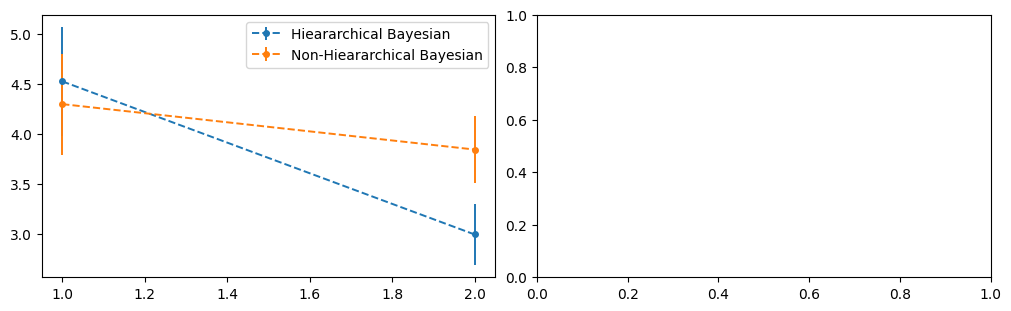

In [63]:
ind = 5
lw = 1.4

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[:N_LIM, 0:ind, :, 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

me, sem, std = _process(nhb_all_in_error[:N_LIM, 0:ind, :, 0].reshape(N_LIM, -1))
ax.errorbar(x=np.array(N_space[:N_LIM]), y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)
ax.legend()

In [147]:
nhb_all_in_error[..., 0].reshape(N_LIM, -1).shape

(8, 600)

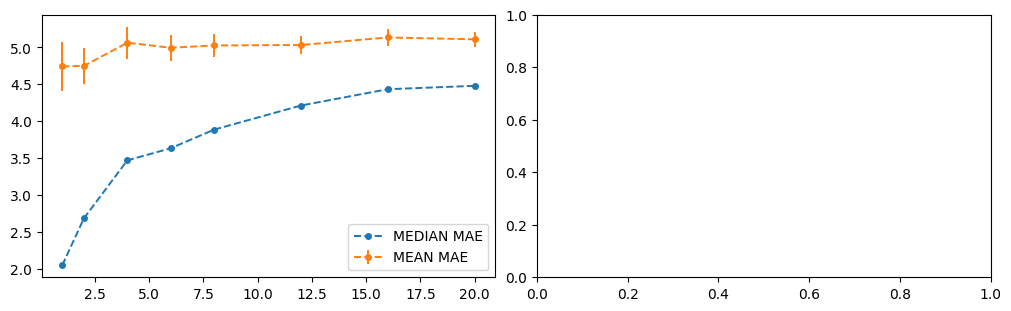

In [155]:
lw = 1.4

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True)
ax = axes[0, 0]

# ax.errorbar(x=N_space[:N_LIM], y=np.median(hbm_error[..., 0].reshape(N_LIM, -1), axis=-1), marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

ax.errorbar(x=np.array(N_space[:N_LIM]), y=np.median(nhb_all_in_error[..., 0].reshape(N_LIM, -1), axis=-1), marker="o", label="MEDIAN MAE", linestyle="--", linewidth=lw, ms=4)


me, sem, std = _process(nhb_all_in_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=np.array(N_space[:N_LIM]), y=me, yerr=sem, marker="o", label="MEAN MAE", linestyle="--", linewidth=lw, ms=4)

ax.legend()

In [129]:
np.median(nhb_all_in_error[..., 0], axis=(-1, -2))

array([2.04391141, 2.68185331, 3.46839431, 3.63224051, 3.88542448,
       4.21213373, 4.43329613, 4.47892915])

In [112]:
nhb_all_in_p_value.shape

(8, 12, 50, 2)

In [23]:
nhbm_error.shape

(8, 12, 50, 3)

2023-10-10 14:53:34,845 - matplotlib.legend - WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


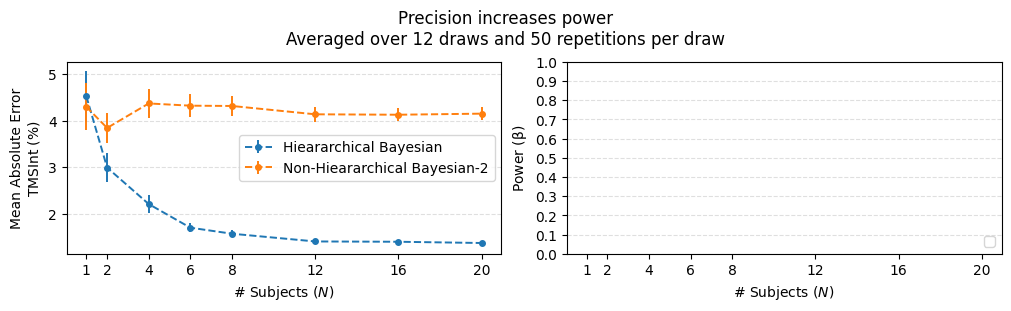

In [85]:
lw = 1.4

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[:, :5, ..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process(nhbm_error[..., 0].reshape(N_LIM, -1))
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process(hb_iterated_error[..., 0].reshape(N_LIM, -1))
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian Iterated", linestyle="--", linewidth=lw, ms=4)

me, sem, std = _process(nhb_all_in_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian-2", linestyle="--", linewidth=lw, ms=4)

ax.legend()
ax.set_xticks(N_space[:N_LIM])
ax.set_ylabel("Mean Absolute Error\nTMSInt $(\%)$")
ax.set_xlabel("# Subjects $(N)$")
ax.grid(axis="y", linestyle="--", alpha=.4);

ax = axes[0, 1]
# me, sem, std = _process_bp(hbm_mu_delta[:, :5, ...])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hiearchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(nhbm_p_value[:, :5, ..., 1])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(hb_iterated_p_value[..., 1])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(nhb_all_in_p_value[..., 1])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(hbm_p_value[:, :5, ..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian Ttest", linestyle="--", linewidth=lw, ms=4)

ax.set_yticks(np.arange(0, 1.1, .1))
ax.grid(axis="y", linestyle="--", alpha=.4)
ax.set_xticks(N_space[:N_LIM])
ax.legend(loc="lower right")
ax.set_xlabel("# Subjects $(N)$")
ax.set_ylabel("Power $($β$)$")
fig.suptitle("Precision increases power\nAveraged over 12 draws and 50 repetitions per draw");

In [86]:
hbm_error.shape

(8, 12, 50, 3)

In [36]:
hb_iterated_p_value.shape

(8, 5, 50, 2)

In [32]:
hbm_mu_delta.shape

(8, 12, 50, 4000, 1, 1)

In [ ]:
lw = 1.4

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[..., 1].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

me, sem, std = _process(nhbm_error[..., 1].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# ax.legend()
ax.set_xticks(N_space[:N_LIM])
ax.set_ylabel("Mean Absolute Error\nTMSInt $(\%)$")
ax.set_xlabel("# Subjects $(N)$")
ax.grid(axis="y", linestyle="--", alpha=.4);

ax = axes[0, 1]
me, sem, std = _process_bp(hbm_mu_delta)
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hiearchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(hbm_p_value[..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb t-test")

# me, sem, std = _process_fp(hbm_p_value[..., 1])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb signed-rank")

# me, sem, std = _process_fp(nhbm_p_value[..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb t-test")

me, sem, std = _process_fp(nhbm_p_value[..., 1])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

ax.set_yticks(np.arange(0, 1.1, .1))
ax.grid(axis="y", linestyle="--", alpha=.4)
ax.set_xticks(N_space[:N_LIM])
ax.legend(loc="lower right")
ax.set_xlabel("# Subjects $(N)$")
ax.set_ylabel("Power $($β$)$")
fig.suptitle("Precision increases power\nAveraged over 12 draws and 50 repetitions per draw");

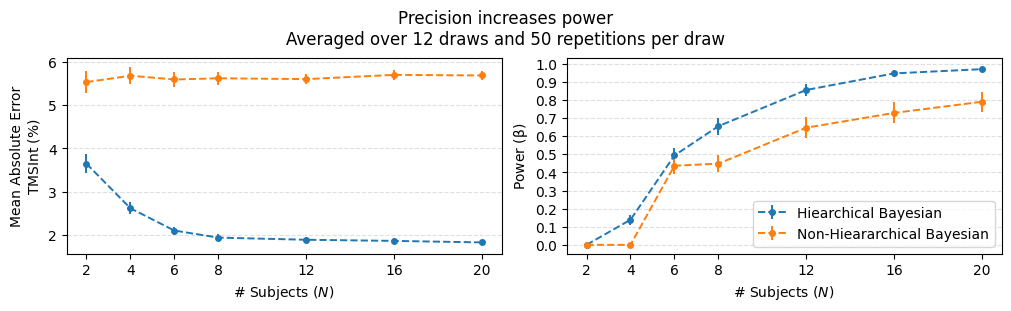

In [47]:
lw = 1.4

nrows, ncols = 1, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 3 * nrows), squeeze=False, constrained_layout=True, sharex=True)
ax = axes[0, 0]

me, sem, std = _process(hbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

me, sem, std = _process(nhbm_error[..., 0].reshape(N_LIM, -1))
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# ax.legend()
ax.set_xticks(N_space[:N_LIM])
ax.set_ylabel("Mean Absolute Error\nTMSInt $(\%)$")
ax.set_xlabel("# Subjects $(N)$")
ax.grid(axis="y", linestyle="--", alpha=.4);

ax = axes[0, 1]
me, sem, std = _process_bp(hbm_mu_delta)
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hiearchical Bayesian", linestyle="--", linewidth=lw, ms=4)

# me, sem, std = _process_fp(hbm_p_value[..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb t-test")

# me, sem, std = _process_fp(hbm_p_value[..., 1])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Hb signed-rank")

# me, sem, std = _process_fp(nhbm_p_value[..., 0])
# ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="nHb t-test")

me, sem, std = _process_fp(nhbm_p_value[..., 1])
ax.errorbar(x=N_space[:N_LIM], y=me, yerr=sem, marker="o", label="Non-Hieararchical Bayesian", linestyle="--", linewidth=lw, ms=4)

ax.set_yticks(np.arange(0, 1.1, .1))
ax.grid(axis="y", linestyle="--", alpha=.4)
ax.set_xticks(N_space[:N_LIM])
ax.legend(loc="lower right")
ax.set_xlabel("# Subjects $(N)$")
ax.set_ylabel("Power $($β$)$")
fig.suptitle("Precision increases power\nAveraged over 12 draws and 50 repetitions per draw");